### V8: Fine-Tune BERT
- Train Data
- Stride 64
- Down Sampling 'O' Label 0.30
- External Dataset
- Evaluation Metric F-Beta5
- Cross Validation

Trained on Kaggle with GPU P100 x1

Leaderboard 
- Public Score: 0.90500
- Private Score: 0.90788

In [1]:
!pip install seqeval
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=c0ae21834ded7be5b3df82a0bcdbe6735ae80f66f14a6c2fa83d64d3cc5fa7af
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [2]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import torch

from datasets import Dataset
from functools import partial
from seqeval.metrics import accuracy_score, classification_report
from transformers import AutoTokenizer
from transformers import DataCollatorForTokenClassification
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from tqdm import tqdm

2024-04-20 08:50:48.319943: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-20 08:50:48.320051: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-20 08:50:48.451492: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
class Setting:
    seed = 42
    base_dir = "/kaggle/input"

    # data
    data_train = f"{base_dir}/pii-detection-removal-from-educational-data/train.json"
    data_nbroad = f"{base_dir}/pii-dd-mistral-generated/mixtral-8x7b-v1.json"
    data_valentinwerner = f"{base_dir}/pii-label-specific-data/all_labels.json"
    data_alejopaulier = f"{base_dir}/fix-punctuation-tokenization-external-dataset/pii_dataset_fixed.json"
    data_pjmathematician = f"{base_dir}/fix-punctuation-tokenization-external-dataset/moredata_dataset_fixed.json"
    data_minhsienweng = f"{base_dir}/create-ai-generated-essays-using-llm/pii_dataset_Gemma.json"
    data_mandrilator = f"{base_dir}/pii-mistral-2k-fit-competition-v2/all_labels.json"

    down_sample_ratio = 0.30
    n_split = 5

    # model
    model_checkpoint = "google-bert/bert-base-uncased"
    model_train = '/kaggle/working/model/v8/train'
    model_final = '/kaggle/working/model/v8/final'
    max_length = 512
    stride = 64

    # hyperparameter
    epochs = 2
    learning_rate = 3e-5
    warmup_ratio = 0.1
    lr_scheduler_type='cosine'
    weight_decay = 0.01
    grad_steps = 2
    batch_size = 16

    # PII (NER) tags
    labels = ["B-EMAIL", "B-ID_NUM", "B-NAME_STUDENT", "B-PHONE_NUM",
              "B-STREET_ADDRESS", "B-URL_PERSONAL", "B-USERNAME",
              "I-ID_NUM", "I-NAME_STUDENT", "I-PHONE_NUM",
              "I-STREET_ADDRESS","I-URL_PERSONAL","O"]
    id2label = dict(enumerate(labels)) # integer label to BIO format label mapping
    label2id = {v:k for k,v in id2label.items()} # BIO format label to integer label mapping
    num_labels = len(labels) # number of PII (NER) tags

In [6]:
np.random.seed(Setting.seed)
torch.manual_seed(Setting.seed)

In [7]:
# read and combine all dataset
df_train = pd.read_json(Setting.data_train)
df_nbroad = pd.read_json(Setting.data_nbroad)
df_valentinwerner = pd.read_json(Setting.data_valentinwerner)
df_alejopaulier = pd.read_json(Setting.data_alejopaulier)
df_pjmathematician = pd.read_json(Setting.data_pjmathematician)
df_minhsienweng = pd.read_json(Setting.data_minhsienweng)
df_mandrilator = pd.read_json(Setting.data_mandrilator)

features = ['tokens', 'labels']
df = pd.concat([df_train[features],
                   df_nbroad[features],
                   df_valentinwerner[features],
                   df_alejopaulier[features],
                   df_pjmathematician[features],
                   df_minhsienweng[features],
                   df_mandrilator[features]],
                   ignore_index=True)

df = df[['tokens', 'labels']]
df.rename(columns={"labels": "pii_labels"}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27442 entries, 0 to 27441
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tokens      27442 non-null  object
 1   pii_labels  27442 non-null  object
dtypes: object(2)
memory usage: 428.9+ KB


In [8]:
def plot_bar_chart(data, target_column, title, xlabel, ylabel):
    target = data[target_column].value_counts(sort=False).reset_index(name='total')
    ax = sns.barplot(
        data=target,
        y='total',
        x=target_column,
        hue=target_column,
        palette='cool',
        estimator=lambda x: sum(x)*100.00/target['total'].sum())
    plt.tight_layout()
    plt.xlabel(xlabel, fontdict={'weight': 'bold'})
    plt.ylabel(ylabel, fontdict={'weight': 'bold'})
    plt.title(title)
    plt.xticks(rotation=0)
    plt.tick_params(axis='both', which='major', labelsize=9)
    # show percentage on bar for first 3 bars
    for index, row in target.iterrows():
        y = row.total*100.00/target['total'].sum()
        ax.text(row.name, y + 0.15, f'{y:.2f}%', fontsize=9)
    ax.get_legend().remove()
    plt.show()

def down_sample(df, down_sample_ratio, seed):
    df['non_pii_entity_only'] = df['pii_labels'].apply(lambda x: sum(label=='O' for label in x)==len(x))

    df_non_pii_entity_only = df[df['non_pii_entity_only']].sample(frac=down_sample_ratio, random_state=seed)
    df_with_pii_entity = df[~df['non_pii_entity_only']]
    df = pd.concat([df_with_pii_entity, df_non_pii_entity_only])

    plot_bar_chart(df, 'non_pii_entity_only', "% of Documents with Non-PII Entity ('O' Label) Only", "Non-PII Entity", "Percentage")
    print(df['non_pii_entity_only'].value_counts())

    df.drop(columns=['non_pii_entity_only'], inplace=True)
    return df

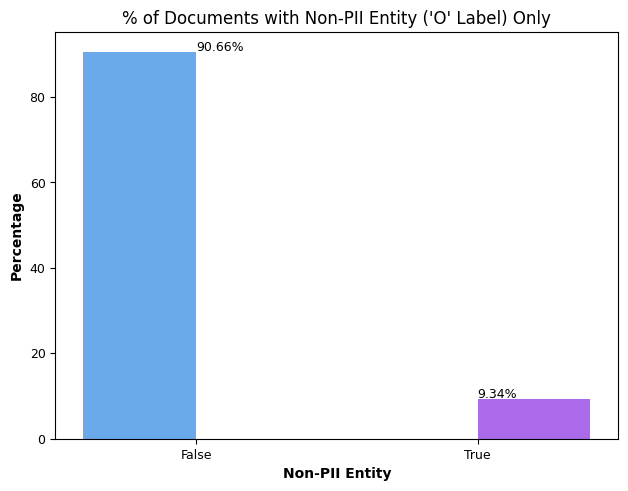

non_pii_entity_only
False    20430
True      2104
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 22534 entries, 0 to 23091
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tokens      22534 non-null  object
 1   pii_labels  22534 non-null  object
dtypes: object(2)
memory usage: 528.1+ KB


In [9]:
df = down_sample(df, Setting.down_sample_ratio, Setting.seed)
df.info()

In [10]:
ds = Dataset.from_pandas(df)
ds

Dataset({
    features: ['tokens', 'pii_labels', '__index_level_0__'],
    num_rows: 22534
})

In [11]:
def tokenize_and_align_labels(example, tokenizer, label2id, max_length, stride):
    tokenized_inputs = tokenizer(example["tokens"],
                                 truncation=True,
                                 max_length=max_length,
                                 stride=stride,
                                 padding="max_length",
                                 is_split_into_words=True,
                                 return_overflowing_tokens=True)
    tokenized_overflow_mappings = tokenized_inputs.overflow_to_sample_mapping
    labels = []
    #print(len(example["tokens"]), len(tokenized_overflow_mappings))
    for idx, overflow_mapping_id in enumerate(tokenized_overflow_mappings):
        label_ids = []
        previous_word_idx = None
        word_ids = tokenized_inputs.word_ids(batch_index=idx) # map tokens to their respective words
        label = example["pii_labels"]
        # using the overflow_mapping_id
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label2id[label[word_idx]])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [12]:
def rearrange_tokenized_input(dataset):
    tokenized = {
        "input_ids": [],
        "labels": [],
        "attention_mask": [],
    }
    for i in tqdm(range(len(dataset))):
        doc = dataset[i]
        for j in range(len(doc["input_ids"])):
            tokenized["input_ids"].append(doc["input_ids"][j])
            tokenized["labels"].append(doc["labels"][j])
            tokenized["attention_mask"].append(doc["attention_mask"][j])
    return tokenized

In [13]:
def compute_metrics(p, id2label):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2label[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    report = classification_report(y_true=true_labels, y_pred=true_predictions, output_dict=True)
    micro_avg = report.pop("micro avg")    
    
    precision = micro_avg["precision"]
    recall = micro_avg["recall"]
    beta = 5
    fbeta = ((1+(beta**2))*precision*recall) / ((beta**2)*precision + recall)
    
    return {
        "precision": precision,
        "recall": recall,
        "f1": micro_avg["f1-score"],
        "fb-5": fbeta
    }

In [14]:
folds = [
    (
        np.array([i for i, d in enumerate(ds["pii_labels"]) if i % Setting.n_split != s]),
        np.array([i for i, d in enumerate(ds["pii_labels"]) if i % Setting.n_split == s])
    )
    for s in tqdm(range(Setting.n_split))
]

100%|██████████| 5/5 [02:35<00:00, 31.04s/it]


In [18]:
tokenizer = AutoTokenizer.from_pretrained(Setting.model_checkpoint)
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir=Setting.model_train,
    num_train_epochs=Setting.epochs,
    learning_rate=Setting.learning_rate,
    lr_scheduler_type=Setting.lr_scheduler_type,
    warmup_ratio=Setting.warmup_ratio,
    weight_decay=Setting.weight_decay,
    gradient_accumulation_steps=Setting.grad_steps,
    per_device_train_batch_size=Setting.batch_size,
    seed=Setting.seed,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="fb-5",
    greater_is_better=True,
    load_best_model_at_end=True
)

for fold_idx, (train_idx, val_idx) in enumerate(folds):        
    train_ds = ds.select(train_idx)
    val_ds = ds.select(val_idx)
    print(f'Fold: {fold_idx}, train_ds: {train_ds.num_rows}, val_ds:  {val_ds.num_rows}')    
    tokenized_train_ds = train_ds.map(tokenize_and_align_labels, 
                                         fn_kwargs={"tokenizer": tokenizer, 
                                                     "label2id": Setting.label2id, 
                                                     "max_length": Setting.max_length,
                                                     "stride": Setting.stride
                                                    }, 
                                         num_proc=os.cpu_count())    
    tokenized_train_ds = tokenized_train_ds.remove_columns(['tokens', 'pii_labels', 'overflow_to_sample_mapping'])    
    tokenized_train_ds = Dataset.from_dict(rearrange_tokenized_input(tokenized_train_ds))    
    tokenized_val_ds = val_ds.map(tokenize_and_align_labels, 
                                     fn_kwargs={"tokenizer": tokenizer, 
                                                 "label2id": Setting.label2id, 
                                                 "max_length": Setting.max_length,
                                                 "stride": Setting.stride
                                                }, 
                                     num_proc=os.cpu_count()) 
    tokenized_val_ds = tokenized_val_ds.remove_columns(['tokens', 'pii_labels', 'overflow_to_sample_mapping'])    
    tokenized_val_ds = Dataset.from_dict(rearrange_tokenized_input(tokenized_val_ds))
    print(f'Fold: {fold_idx}, tokenized_train_ds: {tokenized_train_ds.num_rows}, tokenized_val_ds:  {tokenized_val_ds.num_rows}') 
    
    model = AutoModelForTokenClassification.from_pretrained(
        Setting.model_checkpoint, 
        num_labels=Setting.num_labels, 
        id2label=Setting.id2label, 
        label2id=Setting.label2id
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_ds,
        eval_dataset=tokenized_val_ds,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=partial(compute_metrics, id2label=Setting.id2label)
    )
    
    trainer.train()
    # set best model checkpoint
    Setting.model_checkpoint = trainer.state.best_model_checkpoint
    print(Setting.model_checkpoint)
    trainer.save_model(Setting.model_final)
    tokenizer.save_pretrained(Setting.model_final)

    del trainer
    gc.collect()
    torch.cuda.empty_cache()
    print('------------------------------------------------------')

Fold: 0, train_ds: 18027, val_ds:  4507


Map (num_proc=4):   0%|          | 0/18027 [00:00<?, ? examples/s]

100%|██████████| 18027/18027 [00:39<00:00, 460.63it/s]


Map (num_proc=4):   0%|          | 0/4507 [00:00<?, ? examples/s]

100%|██████████| 4507/4507 [00:10<00:00, 435.62it/s]


Fold: 0, tokenized_train_ds: 27580, tokenized_val_ds:  6887


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Pas

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Fb-5
1,0.174100,0.009989,0.911086,0.890712,0.900784,0.891479
2,0.008300,0.008553,0.946958,0.879353,0.911904,0.881774


/kaggle/working/model/v8/train/checkpoint-862
------------------------------------------------------
Fold: 1, train_ds: 18027, val_ds:  4507


Map (num_proc=4):   0%|          | 0/18027 [00:00<?, ? examples/s]

100%|██████████| 18027/18027 [00:37<00:00, 482.36it/s]


Map (num_proc=4):   0%|          | 0/4507 [00:00<?, ? examples/s]

100%|██████████| 4507/4507 [00:09<00:00, 480.31it/s]


Fold: 1, tokenized_train_ds: 27549, tokenized_val_ds:  6918


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Fb-5
1,0.009400,0.007399,0.951926,0.883976,0.916694,0.886410
2,0.005900,0.006687,0.950806,0.894169,0.921618,0.896222


/kaggle/working/model/v8/train/checkpoint-1722
------------------------------------------------------
Fold: 2, train_ds: 18027, val_ds:  4507


Map (num_proc=4):   0%|          | 0/18027 [00:00<?, ? examples/s]

100%|██████████| 18027/18027 [00:37<00:00, 483.39it/s]


Map (num_proc=4):   0%|          | 0/4507 [00:00<?, ? examples/s]

100%|██████████| 4507/4507 [00:09<00:00, 480.24it/s]


Fold: 2, tokenized_train_ds: 27619, tokenized_val_ds:  6848


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Fb-5
0,0.006300,0.006182,0.965396,0.890964,0.926688,0.893614
1,0.004700,0.005463,0.946946,0.917810,0.932150,0.918897


/kaggle/working/model/v8/train/checkpoint-1726
------------------------------------------------------
Fold: 3, train_ds: 18027, val_ds:  4507


Map (num_proc=4):   0%|          | 0/18027 [00:00<?, ? examples/s]

100%|██████████| 18027/18027 [00:38<00:00, 465.24it/s]


Map (num_proc=4):   0%|          | 0/4507 [00:00<?, ? examples/s]

100%|██████████| 4507/4507 [00:10<00:00, 438.11it/s]


Fold: 3, tokenized_train_ds: 27597, tokenized_val_ds:  6870


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Fb-5
0,0.005600,0.004923,0.979414,0.888275,0.931621,0.891466
1,0.004100,0.004557,0.964665,0.925188,0.944514,0.926647


/kaggle/working/model/v8/train/checkpoint-1724
------------------------------------------------------
Fold: 4, train_ds: 18028, val_ds:  4506


Map (num_proc=4):   0%|          | 0/18028 [00:00<?, ? examples/s]

100%|██████████| 18028/18028 [00:37<00:00, 484.89it/s]


Map (num_proc=4):   0%|          | 0/4506 [00:00<?, ? examples/s]

100%|██████████| 4506/4506 [00:09<00:00, 486.80it/s]


Fold: 4, tokenized_train_ds: 27523, tokenized_val_ds:  6944


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Fb-5
0,0.004800,0.003666,0.956774,0.941673,0.949164,0.942245
1,0.003200,0.003243,0.961192,0.949955,0.955540,0.950382


/kaggle/working/model/v8/train/checkpoint-1720
------------------------------------------------------


In [21]:
Setting.epochs = 1
Setting.model_final = '/kaggle/working/model/v8_fp15/final'
print(Setting.model_checkpoint)
print(Setting.epochs)
print(Setting.model_final)

/kaggle/working/model/v8/train/checkpoint-1720
1
/kaggle/working/model/v8_fp15/final


In [ ]:
training_args = TrainingArguments(
    output_dir=Setting.model_train,
    num_train_epochs=Setting.epochs,
    learning_rate=Setting.learning_rate,
    lr_scheduler_type=Setting.lr_scheduler_type,
    warmup_ratio=Setting.warmup_ratio,
    weight_decay=Setting.weight_decay,
    gradient_accumulation_steps=Setting.grad_steps,
    per_device_train_batch_size=Setting.batch_size,
    seed=Setting.seed,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="fb-5",
    greater_is_better=True,
    load_best_model_at_end=True
)

for fold_idx, (train_idx, val_idx) in enumerate(folds):        
    train_ds = ds.select(train_idx)
    val_ds = ds.select(val_idx)
    print(f'Fold: {fold_idx}, train_ds: {train_ds.num_rows}, val_ds:  {val_ds.num_rows}')    
    tokenized_train_ds = train_ds.map(tokenize_and_align_labels, 
                                         fn_kwargs={"tokenizer": tokenizer, 
                                                     "label2id": Setting.label2id, 
                                                     "max_length": Setting.max_length,
                                                     "stride": Setting.stride
                                                    }, 
                                         num_proc=os.cpu_count())    
    tokenized_train_ds = tokenized_train_ds.remove_columns(['tokens', 'pii_labels', 'overflow_to_sample_mapping'])    
    tokenized_train_ds = Dataset.from_dict(rearrange_tokenized_input(tokenized_train_ds))    
    tokenized_val_ds = val_ds.map(tokenize_and_align_labels, 
                                     fn_kwargs={"tokenizer": tokenizer, 
                                                 "label2id": Setting.label2id, 
                                                 "max_length": Setting.max_length,
                                                 "stride": Setting.stride
                                                }, 
                                     num_proc=os.cpu_count()) 
    tokenized_val_ds = tokenized_val_ds.remove_columns(['tokens', 'pii_labels', 'overflow_to_sample_mapping'])    
    tokenized_val_ds = Dataset.from_dict(rearrange_tokenized_input(tokenized_val_ds))
    print(f'Fold: {fold_idx}, tokenized_train_ds: {tokenized_train_ds.num_rows}, tokenized_val_ds:  {tokenized_val_ds.num_rows}') 
    
    model = AutoModelForTokenClassification.from_pretrained(
        Setting.model_checkpoint, 
        num_labels=Setting.num_labels, 
        id2label=Setting.id2label, 
        label2id=Setting.label2id
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_ds,
        eval_dataset=tokenized_val_ds,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=partial(compute_metrics, id2label=Setting.id2label)
    )
    
    trainer.train()
    # set best model checkpoint
    Setting.model_checkpoint = trainer.state.best_model_checkpoint
    print(Setting.model_checkpoint)
    trainer.save_model(Setting.model_final)
    tokenizer.save_pretrained(Setting.model_final)

    del trainer
    gc.collect()
    torch.cuda.empty_cache()
    print('------------------------------------------------------')

Fold: 0, train_ds: 18027, val_ds:  4507


Map (num_proc=4):   0%|          | 0/18027 [00:00<?, ? examples/s]

100%|██████████| 18027/18027 [00:37<00:00, 481.84it/s]


Map (num_proc=4):   0%|          | 0/4507 [00:00<?, ? examples/s]

100%|██████████| 4507/4507 [00:09<00:00, 474.78it/s]


Fold: 0, tokenized_train_ds: 27580, tokenized_val_ds:  6887


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Fb-5
1,0.003700,0.002556,0.975853,0.959968,0.967845,0.960569


/kaggle/working/model/v8/train/checkpoint-862
------------------------------------------------------
Fold: 1, train_ds: 18027, val_ds:  4507


Map (num_proc=4):   0%|          | 0/18027 [00:00<?, ? examples/s]

100%|██████████| 18027/18027 [00:37<00:00, 480.66it/s]


Map (num_proc=4):   0%|          | 0/4507 [00:00<?, ? examples/s]

100%|██████████| 4507/4507 [00:09<00:00, 484.03it/s]


Fold: 1, tokenized_train_ds: 27549, tokenized_val_ds:  6918


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Fb-5
1,0.003200,0.002261,0.980169,0.953571,0.966687,0.954567


/kaggle/working/model/v8/train/checkpoint-861
------------------------------------------------------
Fold: 2, train_ds: 18027, val_ds:  4507


Map (num_proc=4):   0%|          | 0/18027 [00:00<?, ? examples/s]

100%|██████████| 18027/18027 [00:37<00:00, 484.36it/s]


Map (num_proc=4):   0%|          | 0/4507 [00:00<?, ? examples/s]

100%|██████████| 4507/4507 [00:09<00:00, 485.24it/s]


Fold: 2, tokenized_train_ds: 27619, tokenized_val_ds:  6848


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss


In [15]:
Setting.model_checkpoint = '/kaggle/input/bert/transformers/v2-ep12/1'
Setting.epochs = 1
Setting.model_final = '/kaggle/working/model/v8_fp15/final'
print(Setting.model_checkpoint)
print(Setting.epochs)
print(Setting.model_final)

/kaggle/input/bert/transformers/v2-ep12/1
1
/kaggle/working/model/v8_fp15/final


In [17]:
tokenizer = AutoTokenizer.from_pretrained(Setting.model_checkpoint)
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir=Setting.model_train,
    num_train_epochs=Setting.epochs,
    learning_rate=Setting.learning_rate,
    lr_scheduler_type=Setting.lr_scheduler_type,
    warmup_ratio=Setting.warmup_ratio,
    weight_decay=Setting.weight_decay,
    gradient_accumulation_steps=Setting.grad_steps,
    per_device_train_batch_size=Setting.batch_size,
    seed=Setting.seed,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="fb-5",
    greater_is_better=True,
    load_best_model_at_end=True
)

for fold_idx, (train_idx, val_idx) in enumerate(folds): 
    if fold_idx < 2:
        continue
    train_ds = ds.select(train_idx)
    val_ds = ds.select(val_idx)
    print(f'Fold: {fold_idx}, train_ds: {train_ds.num_rows}, val_ds:  {val_ds.num_rows}')    
    tokenized_train_ds = train_ds.map(tokenize_and_align_labels, 
                                         fn_kwargs={"tokenizer": tokenizer, 
                                                     "label2id": Setting.label2id, 
                                                     "max_length": Setting.max_length,
                                                     "stride": Setting.stride
                                                    }, 
                                         num_proc=os.cpu_count())    
    tokenized_train_ds = tokenized_train_ds.remove_columns(['tokens', 'pii_labels', 'overflow_to_sample_mapping'])    
    tokenized_train_ds = Dataset.from_dict(rearrange_tokenized_input(tokenized_train_ds))    
    tokenized_val_ds = val_ds.map(tokenize_and_align_labels, 
                                     fn_kwargs={"tokenizer": tokenizer, 
                                                 "label2id": Setting.label2id, 
                                                 "max_length": Setting.max_length,
                                                 "stride": Setting.stride
                                                }, 
                                     num_proc=os.cpu_count()) 
    tokenized_val_ds = tokenized_val_ds.remove_columns(['tokens', 'pii_labels', 'overflow_to_sample_mapping'])    
    tokenized_val_ds = Dataset.from_dict(rearrange_tokenized_input(tokenized_val_ds))
    print(f'Fold: {fold_idx}, tokenized_train_ds: {tokenized_train_ds.num_rows}, tokenized_val_ds:  {tokenized_val_ds.num_rows}') 
    
    model = AutoModelForTokenClassification.from_pretrained(
        Setting.model_checkpoint, 
        num_labels=Setting.num_labels, 
        id2label=Setting.id2label, 
        label2id=Setting.label2id
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_ds,
        eval_dataset=tokenized_val_ds,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=partial(compute_metrics, id2label=Setting.id2label)
    )
    
    trainer.train()
    # set best model checkpoint
    Setting.model_checkpoint = trainer.state.best_model_checkpoint
    print(Setting.model_checkpoint)
    trainer.save_model(Setting.model_final)
    tokenizer.save_pretrained(Setting.model_final)

    del trainer
    gc.collect()
    torch.cuda.empty_cache()
    print('------------------------------------------------------')

Fold: 2, train_ds: 18027, val_ds:  4507


Map (num_proc=4):   0%|          | 0/18027 [00:00<?, ? examples/s]

100%|██████████| 18027/18027 [00:39<00:00, 455.38it/s]


Map (num_proc=4):   0%|          | 0/4507 [00:00<?, ? examples/s]

100%|██████████| 4507/4507 [00:10<00:00, 423.59it/s]


Fold: 2, tokenized_train_ds: 27619, tokenized_val_ds:  6848


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Fb-5
0,0.002700,0.001873,0.980438,0.970107,0.975245,0.970500


/kaggle/working/model/v8/train/checkpoint-863
------------------------------------------------------
Fold: 3, train_ds: 18027, val_ds:  4507


Map (num_proc=4):   0%|          | 0/18027 [00:00<?, ? examples/s]

100%|██████████| 18027/18027 [00:40<00:00, 450.39it/s]


Map (num_proc=4):   0%|          | 0/4507 [00:00<?, ? examples/s]

100%|██████████| 4507/4507 [00:10<00:00, 448.63it/s]


Fold: 3, tokenized_train_ds: 27597, tokenized_val_ds:  6870


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Fb-5
0,0.002500,0.001446,0.985706,0.981461,0.983579,0.981624


/kaggle/working/model/v8/train/checkpoint-862
------------------------------------------------------
Fold: 4, train_ds: 18028, val_ds:  4506


Map (num_proc=4):   0%|          | 0/18028 [00:00<?, ? examples/s]

100%|██████████| 18028/18028 [00:40<00:00, 447.33it/s]


Map (num_proc=4):   0%|          | 0/4506 [00:00<?, ? examples/s]

100%|██████████| 4506/4506 [00:10<00:00, 443.55it/s]


Fold: 4, tokenized_train_ds: 27523, tokenized_val_ds:  6944


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Fb-5
0,0.002200,0.001243,0.983636,0.987757,0.985692,0.987597


/kaggle/working/model/v8/train/checkpoint-860
------------------------------------------------------


In [ ]:
import shutil
shutil.make_archive('v8_fp15', 'zip', Setting.model_final)

In [21]:
Setting.epochs = 1
Setting.model_final = '/kaggle/working/model/v8_fp20/final'
print(Setting.model_checkpoint)
print(Setting.epochs)
print(Setting.model_final)

/kaggle/working/model/v8/train/checkpoint-860
1
/kaggle/working/model/v8_fp20/final


In [22]:
training_args = TrainingArguments(
    output_dir=Setting.model_train,
    num_train_epochs=Setting.epochs,
    learning_rate=Setting.learning_rate,
    lr_scheduler_type=Setting.lr_scheduler_type,
    warmup_ratio=Setting.warmup_ratio,
    weight_decay=Setting.weight_decay,
    gradient_accumulation_steps=Setting.grad_steps,
    per_device_train_batch_size=Setting.batch_size,
    seed=Setting.seed,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="fb-5",
    greater_is_better=True,
    load_best_model_at_end=True
)

for fold_idx, (train_idx, val_idx) in enumerate(folds):        
    train_ds = ds.select(train_idx)
    val_ds = ds.select(val_idx)
    print(f'Fold: {fold_idx}, train_ds: {train_ds.num_rows}, val_ds:  {val_ds.num_rows}')    
    tokenized_train_ds = train_ds.map(tokenize_and_align_labels, 
                                         fn_kwargs={"tokenizer": tokenizer, 
                                                     "label2id": Setting.label2id, 
                                                     "max_length": Setting.max_length,
                                                     "stride": Setting.stride
                                                    }, 
                                         num_proc=os.cpu_count())    
    tokenized_train_ds = tokenized_train_ds.remove_columns(['tokens', 'pii_labels', 'overflow_to_sample_mapping'])    
    tokenized_train_ds = Dataset.from_dict(rearrange_tokenized_input(tokenized_train_ds))    
    tokenized_val_ds = val_ds.map(tokenize_and_align_labels, 
                                     fn_kwargs={"tokenizer": tokenizer, 
                                                 "label2id": Setting.label2id, 
                                                 "max_length": Setting.max_length,
                                                 "stride": Setting.stride
                                                }, 
                                     num_proc=os.cpu_count()) 
    tokenized_val_ds = tokenized_val_ds.remove_columns(['tokens', 'pii_labels', 'overflow_to_sample_mapping'])    
    tokenized_val_ds = Dataset.from_dict(rearrange_tokenized_input(tokenized_val_ds))
    print(f'Fold: {fold_idx}, tokenized_train_ds: {tokenized_train_ds.num_rows}, tokenized_val_ds:  {tokenized_val_ds.num_rows}') 
    
    model = AutoModelForTokenClassification.from_pretrained(
        Setting.model_checkpoint, 
        num_labels=Setting.num_labels, 
        id2label=Setting.id2label, 
        label2id=Setting.label2id
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_ds,
        eval_dataset=tokenized_val_ds,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=partial(compute_metrics, id2label=Setting.id2label)
    )
    
    trainer.train()
    # set best model checkpoint
    Setting.model_checkpoint = trainer.state.best_model_checkpoint
    print(Setting.model_checkpoint)
    trainer.save_model(Setting.model_final)
    tokenizer.save_pretrained(Setting.model_final)

    del trainer
    gc.collect()
    torch.cuda.empty_cache()
    print('------------------------------------------------------')

Fold: 0, train_ds: 18027, val_ds:  4507


Map (num_proc=4):   0%|          | 0/18027 [00:00<?, ? examples/s]

100%|██████████| 18027/18027 [00:39<00:00, 451.87it/s]


Map (num_proc=4):   0%|          | 0/4507 [00:00<?, ? examples/s]

100%|██████████| 4507/4507 [00:09<00:00, 463.05it/s]


Fold: 0, tokenized_train_ds: 27580, tokenized_val_ds:  6887


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Fb-5
1,0.001500,0.000991,0.989451,0.989515,0.989483,0.989512


/kaggle/working/model/v8/train/checkpoint-862
------------------------------------------------------
Fold: 1, train_ds: 18027, val_ds:  4507


Map (num_proc=4):   0%|          | 0/18027 [00:00<?, ? examples/s]

100%|██████████| 18027/18027 [00:40<00:00, 450.24it/s]


Map (num_proc=4):   0%|          | 0/4507 [00:00<?, ? examples/s]

100%|██████████| 4507/4507 [00:09<00:00, 454.48it/s]


Fold: 1, tokenized_train_ds: 27549, tokenized_val_ds:  6918


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Fb-5
1,0.001500,0.000982,0.991269,0.984413,0.987829,0.984675


/kaggle/working/model/v8/train/checkpoint-861
------------------------------------------------------
Fold: 2, train_ds: 18027, val_ds:  4507


Map (num_proc=4):   0%|          | 0/18027 [00:00<?, ? examples/s]

100%|██████████| 18027/18027 [00:40<00:00, 446.86it/s]


Map (num_proc=4):   0%|          | 0/4507 [00:00<?, ? examples/s]

100%|██████████| 4507/4507 [00:09<00:00, 455.26it/s]


Fold: 2, tokenized_train_ds: 27619, tokenized_val_ds:  6848


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Fb-5
0,0.001200,0.000915,0.993120,0.987453,0.990278,0.987669


/kaggle/working/model/v8/train/checkpoint-863
------------------------------------------------------
Fold: 3, train_ds: 18027, val_ds:  4507


Map (num_proc=4):   0%|          | 0/18027 [00:00<?, ? examples/s]

100%|██████████| 18027/18027 [00:39<00:00, 459.20it/s]


Map (num_proc=4):   0%|          | 0/4507 [00:00<?, ? examples/s]

100%|██████████| 4507/4507 [00:09<00:00, 459.35it/s]


Fold: 3, tokenized_train_ds: 27597, tokenized_val_ds:  6870


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Fb-5
0,0.001200,0.000772,0.991618,0.991552,0.991585,0.991555


/kaggle/working/model/v8/train/checkpoint-862
------------------------------------------------------
Fold: 4, train_ds: 18028, val_ds:  4506


Map (num_proc=4):   0%|          | 0/18028 [00:00<?, ? examples/s]

100%|██████████| 18028/18028 [00:39<00:00, 457.71it/s]


Map (num_proc=4):   0%|          | 0/4506 [00:00<?, ? examples/s]

100%|██████████| 4506/4506 [00:09<00:00, 459.08it/s]


Fold: 4, tokenized_train_ds: 27523, tokenized_val_ds:  6944


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Fb-5
0,0.001300,0.000970,0.994336,0.986393,0.990349,0.986696


/kaggle/working/model/v8/train/checkpoint-860
------------------------------------------------------


In [23]:
shutil.make_archive('v8_fp20', 'zip', Setting.model_final)

'/kaggle/working/v8_fp20.zip'